In [1]:
!pip install numpy_groupies
!pip install xrft==0.4.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46057")
client

<Client: 'tcp://127.0.0.1:46057' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:39679' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
# plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
for entry in params_dict.keys():
    print(f"{entry} parameters and their allowable args are:")
    description = cat[entry].describe()
    params = description["user_parameters"]
    if len(params) != 0:
        for i in range(len(params)):
            print(f"""    {params[i]["name"]}: {params[i]["allowed"]}""")            
    else:
        print("    Not implemented.")
    print()

GIGATL parameters and their allowable args are:
    region: ['1', '2']
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

HYCOM50 parameters and their allowable args are:
    region: ['1_GS', '2_GE', '3_MD']
    datatype: ['surf', 'int', 'int_wvel', 'grid']
    season: ['fma', 'aso', '']
    grid: ['grid', '']

eNATL60 parameters and their allowable args are:
    region: ['1', '2', '3']
    datatype: ['surface_hourly', 'interior_daily']
    season: ['fma', 'aso']

FESOM parameters and their allowable args are:
    datatype: ['surf', 'int']
    season: ['fma', 'aso']

ORCA36 parameters and their allowable args are:
    region: ['1', '2', '3', '4']
    datatype: ['surface_hourly', 'interior_daily', 'grid']
    season: ['fma', 'aso', '']
    grid: ['bathymetry', 'meshmask', '']



In [7]:
cs = 0.30404039  # 10th internal wave phase speed

# Load data

In [8]:
enatlw = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                    ).to_dask().isel(y=slice(None,660),x=slice(210,None))

In [9]:
hycomw = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False
                    ).to_dask().isel(lon=slice(180,None),lat=slice(None,520))
hycom_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid'
                        ).to_dask().isel(lon=slice(180,None),lat=slice(None,520))

In [10]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
    
gigaw = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma'
                                ).to_dask()
                     ).isel(eta_rho=slice(80,980),xi_rho=slice(700,None),
                            eta_v=slice(81,980),xi_u=slice(700,None))

gridg = gigaw.attrs["xgcm-Grid"]

mask_rho = gigaw.salt.where(gigaw.salt==0.).isel(time=0)
mask_u = gridg.interp(mask_rho, 'xi')
mask_v = gridg.interp(mask_rho, 'eta')
mask_psi = gridg.interp(gridg.interp(mask_rho, 'eta'), 'xi')

In [11]:
fesomw = cat.FESOM(datatype='surf', season='fma').to_dask().isel(lat=slice(None,850),lon=slice(340,None))

In [12]:
orcaw = cat.ORCA36(region='1', datatype='surface_hourly', season='fma'
                  ).to_dask().isel(y=slice(None,385),x=slice(125,None))
orca_grid = cat.ORCA36(region='1', datatype='grid',grid='meshmask'
                      ).to_dask().isel(y=slice(None,385),x=slice(125,None))

In [13]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()

istart = 497664
di = 144
# iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)
iters = np.arange(istart+29*24*di,
                  istart+(29+31)*24*di,di)
nskip = 1

llcw = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                         iters=iters[::nskip],
                         type='latlon').sel(k=0,
                                            j=slice(9555,10198-115),j_g=slice(9555,10198-115),
                                            i=slice(15355+170,15845),i_g=slice(15355+170,15845)
#                                               time=slice('2012-02-01','2012-04-30'),
#                                             j=slice(9745,9745+250),j_g=slice(9745,9745+250),
#                                             i=slice(15355+350,15845),i_g=slice(15355+350,15845),
                                           )

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llcw, periodic=[],
               coords={
#                        'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )

In [14]:
Uenatlw = .5*(enatlw.sozocrtx + np.roll(enatlw.sozocrtx,1,-1))
Venatlw = .5*(enatlw.somecrty + np.roll(enatlw.somecrty,1,-2))

In [15]:
Uorcaw = .5*(orcaw.uos + np.roll(orcaw.uos,1,-1))
Vorcaw = .5*(orcaw.vos + np.roll(orcaw.vos,1,-2))

In [16]:
Ugigaw = gridg.interp(gigaw.u.where(mask_u!=0.), 'xi', boundary='extend')
Vgigaw = gridg.interp(gigaw.v.where(mask_v!=0.), 'eta', boundary='extend')

In [17]:
Uhycomw = .5*(hycomw.uu1 + np.roll(hycomw.uu1,1,-1))
Vhycomw = .5*(hycomw.vv1 + np.roll(hycomw.vv1,1,-2))

/tmp/ipykernel_2714/2425913688.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,1].pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.),


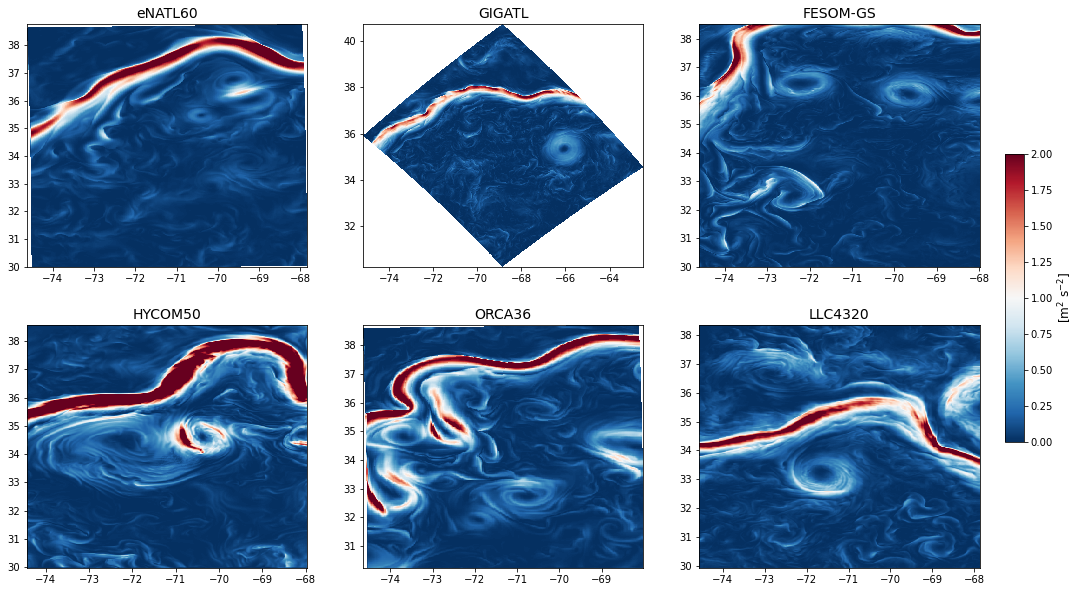

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(enatlw.lon, enatlw.lat, 
                           .5*(Uenatlw.isel(time_counter=0)**2 + Venatlw.isel(time_counter=0)**2), 
                           cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')
axes[0,1].pcolormesh(gigaw.lon, gigaw.lat, 
                   .5*(Ugigaw.isel(time=0)**2+Vgigaw.isel(time=0)**2),
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[0,2].pcolormesh(fesomw.lon, fesomw.lat, 
                   .5*(fesomw.u_surf.isel(time=0)**2 + fesomw.v_surf.isel(time=0)**2), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[1,0].pcolormesh(hycom_grid.longitude, hycom_grid.latitude, 
                   .5*(Uhycomw.isel(time=0)**2 + Vhycomw.isel(time=0)**2), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[1,1].pcolor(orcaw.nav_lon.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
               orcaw.nav_lat.where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
               .5*(Uorcaw.isel(time_counter=0)**2 + Vorcaw.isel(time_counter=0)**2
                  ).where(orca_grid.tmask.isel(time_counter=0,nav_lev=0)!=0.), 
               cmap='RdBu_r', vmax=2, vmin=0, rasterized=True)

axes[1,2].pcolormesh(llcw.XC, llcw.YC,
                   .5*(gridllc.interp(llcw.U.isel(time=0)**2,'X',boundary='extend')
                       + gridllc.interp(llcw.V.isel(time=0)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[0,0].set_title(r"eNATL60", fontsize=14)
axes[0,1].set_title(r"GIGATL", fontsize=14)
axes[0,2].set_title(r"FESOM-GS", fontsize=14)
axes[1,0].set_title(r"HYCOM50", fontsize=14)
axes[1,1].set_title(r"ORCA36", fontsize=14)
axes[1,2].set_title(r"LLC4320", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.24) 
cbax = fig.add_axes([0.88, 0.3, 0.014, 0.4])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

# Assume a local Cartesian plane

In [19]:
Ny = len(enatlw.y)
Nx = len(enatlw.x)
dx = enatlw.e1t.mean(skipna=True)
dy = enatlw.e2t.mean(skipna=True)

    
U_enatlw = xr.DataArray(Uenatlw.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(enatlw.time_counter))*3600,
                                'YC':np.arange(0,Ny*dy,dy),
                                'XC':np.arange(0,Nx*dx,dx)[:-1]}
                       ).chunk({'time':100,'YC':-1,'XC':-1})
V_enatlw = xr.DataArray(Venatlw.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(enatlw.time_counter))*3600,
                                'YC':np.arange(0,Ny*dy,dy),
                                'XC':np.arange(0,Nx*dx,dx)[:-1]}
                       ).chunk({'time':100,'YC':-1,'XC':-1})

In [20]:
Ny = len(orcaw.y)
Nx = len(orcaw.x)
dx = orca_grid.e1t.mean(skipna=True)
dy = orca_grid.e2t.mean(skipna=True)

    
U_orcaw = xr.DataArray(Uorcaw.data, dims=['time','YC','XC'],
                       coords={'time':np.arange(len(orcaw.time_counter))*3600,
                               'YC':np.arange(0,Ny*dy,dy),
                               'XC':np.arange(0,Nx*dx,dx)}
                      ).chunk({'time':100,'YC':-1,'XC':-1})
V_orcaw = xr.DataArray(Vorcaw.data, dims=['time','YC','XC'],
                       coords={'time':np.arange(len(orcaw.time_counter))*3600,
                               'YC':np.arange(0,Ny*dy,dy),
                               'XC':np.arange(0,Nx*dx,dx)}
                      ).chunk({'time':100,'YC':-1,'XC':-1})

In [21]:
Ny = len(gigaw.eta_rho)
Nx = len(gigaw.xi_rho)
dx = (gigaw.pm**-1).mean(skipna=True)
dy = (gigaw.pn**-1).mean(skipna=True)

    
U_gigaw = xr.DataArray(Ugigaw.data, 
                       dims=['time','YC','XC'],
                       coords={'time':np.arange(len(gigaw.time))*3600,
                               'YC':np.arange(0,(Ny)*dy,dy),
                               'XC':np.arange(0,(Nx)*dx,dx)}
                      ).chunk({'time':100,'YC':-1,'XC':-1})
V_gigaw = xr.DataArray(Vgigaw.data, dims=['time','YC','XC'],
                       coords={'time':np.arange(len(gigaw.time))*3600,
                               'YC':np.arange(0,(Ny)*dy,dy),
                               'XC':np.arange(0,(Nx)*dx,dx)}
                      ).chunk({'time':100,'YC':-1,'XC':-1})

In [22]:
Ny = len(fesomw.lat)
Nx = len(fesomw.lon)
import gsw
xx, yy = np.meshgrid(fesomw.lon, fesomw.lat)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

fesomw.coords['dx'] = (('lat','lon'), dx.data)
fesomw.coords['dy'] = (('lat','lon'), dy.data)

Ny = len(fesomw.lat)
Nx = len(fesomw.lon)
dx = (fesomw.dx).mean(skipna=True)
dy = (fesomw.dy).mean(skipna=True)

    
U_fesomw = xr.DataArray(fesomw.u_surf.data, 
                        dims=['time','YC','XC'],
                        coords={'time':np.arange(len(fesomw.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':100,'YC':-1,'XC':-1})
V_fesomw = xr.DataArray(fesomw.v_surf.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(fesomw.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':100,'YC':-1,'XC':-1})

In [23]:
Ny = len(hycom_grid.lat)
Nx = len(hycom_grid.lon)
import gsw
xx, yy = np.meshgrid(hycom_grid.longitude, hycom_grid.latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(Ny),'lon':np.arange(.5,Nx-1,1)}
                 ).interp(lon=np.arange(Nx), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,Ny-1,1),'lon':np.arange(Nx)}
                 ).interp(lat=np.arange(Ny), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycomw.coords['dx'] = (('lat','lon'), dx.data)
hycomw.coords['dy'] = (('lat','lon'), dy.data)

Ny = len(hycomw.lat)
Nx = len(hycomw.lon)
dx = (hycomw.dx).mean(skipna=True)
dy = (hycomw.dy).mean(skipna=True)

    
U_hycomw = xr.DataArray(Uhycomw.data, 
                        dims=['time','YC','XC'],
                        coords={'time':np.arange(len(hycomw.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':100,'YC':-1,'XC':-1})
V_hycomw = xr.DataArray(Vhycomw.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(hycomw.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':100,'YC':-1,'XC':-1})

# Take the $\omega$-$k$ Fourier transform

In [24]:
Fu_enatlw = xrft.fft(xrft.fft(U_enatlw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fu_enatlw = Fu_enatlw.isel(freq_time=slice(len(Fu_enatlw.freq_time)//2,None)) * 2

Fv_enatlw = xrft.fft(xrft.fft(V_enatlw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fv_enatlw = Fv_enatlw.isel(freq_time=slice(len(Fv_enatlw.freq_time)//2,None)) * 2

In [25]:
Fu_gigaw = xrft.fft(xrft.fft(U_gigaw.fillna(0.), 
                             dim=['YC','XC'], window='hann', detrend='constant', 
                             true_phase=True, true_amplitude=True
                            ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                    dim=['time'], window='hann', detrend='constant', 
                    true_phase=True, true_amplitude=True
                   )
Fu_gigaw = Fu_gigaw.isel(freq_time=slice(len(Fu_gigaw.freq_time)//2,None)) * 2

Fv_gigaw = xrft.fft(xrft.fft(V_gigaw.fillna(0.), 
                             dim=['YC','XC'], window='hann', detrend='constant', 
                             true_phase=True, true_amplitude=True
                            ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                    dim=['time'], window='hann', detrend='constant', 
                    true_phase=True, true_amplitude=True
                   )
Fv_gigaw = Fv_gigaw.isel(freq_time=slice(len(Fv_gigaw.freq_time)//2,None)) * 2

In [26]:
Fu_fesomw = xrft.fft(xrft.fft(U_fesomw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fu_fesomw = Fu_fesomw.isel(freq_time=slice(len(Fu_fesomw.freq_time)//2,None)) * 2

Fv_fesomw = xrft.fft(xrft.fft(V_fesomw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fv_fesomw = Fv_fesomw.isel(freq_time=slice(len(Fv_fesomw.freq_time)//2,None)) * 2

In [27]:
Fu_hycomw = xrft.fft(xrft.fft(U_hycomw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fu_hycomw = Fu_hycomw.isel(freq_time=slice(len(Fu_hycomw.freq_time)//2,None)) * 2

Fv_hycomw = xrft.fft(xrft.fft(V_hycomw.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )
Fv_hycomw = Fv_hycomw.isel(freq_time=slice(len(Fv_hycomw.freq_time)//2,None)) * 2

In [28]:
Fu_orcaw = xrft.fft(xrft.fft(U_orcaw.fillna(0.), 
                             dim=['YC','XC'], window='hann', detrend='constant', 
                             true_phase=True, true_amplitude=True
                            ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                    dim=['time'], window='hann', detrend='constant', 
                    true_phase=True, true_amplitude=True
                   )
Fu_orcaw = Fu_orcaw.isel(freq_time=slice(len(Fu_orcaw.freq_time)//2,None)) * 2

Fv_orcaw = xrft.fft(xrft.fft(V_orcaw.fillna(0.), 
                             dim=['YC','XC'], window='hann', detrend='constant', 
                             true_phase=True, true_amplitude=True
                            ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                    dim=['time'], window='hann', detrend='constant', 
                    true_phase=True, true_amplitude=True
                   )
Fv_orcaw = Fv_orcaw.isel(freq_time=slice(len(Fv_orcaw.freq_time)//2,None)) * 2

# Function to isotropize the power spectra

In [29]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. "
            + "Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            pass

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [30]:
def density(ps, dim):
    ff = np.prod([float(ps[d].spacing) for d in dim])
    return ps * ff

In [31]:
isoFu_enatlw = isotropize(density(np.abs(Fu_enatlw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']), 
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute() 
isoFv_enatlw = isotropize(density(np.abs(Fv_enatlw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']),  
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute()

In [32]:
isoFu_orcaw = isotropize(density(np.abs(Fu_orcaw.chunk({'freq_time':10}))**2,
                                 ['freq_time','freq_YC','freq_XC']), 
                         ['freq_YC','freq_XC'], nfactor=4, 
                         kwargs={'truncate':True}
                        ).compute() 
isoFv_orcaw = isotropize(density(np.abs(Fv_orcaw.chunk({'freq_time':10}))**2,
                                 ['freq_time','freq_YC','freq_XC']),  
                         ['freq_YC','freq_XC'], nfactor=4, 
                         kwargs={'truncate':True}
                        ).compute()

In [33]:
isoFu_gigaw = isotropize(density(np.abs(Fu_gigaw.chunk({'freq_time':10}))**2,
                                 ['freq_time','freq_YC','freq_XC']), 
                         ['freq_YC','freq_XC'], nfactor=4, 
                         kwargs={'truncate':True}
                        ).compute() 
isoFv_gigaw = isotropize(density(np.abs(Fv_gigaw.chunk({'freq_time':10}))**2,
                                 ['freq_time','freq_YC','freq_XC']),  
                         ['freq_YC','freq_XC'], nfactor=4, 
                         kwargs={'truncate':True}
                        ).compute()

In [34]:
isoFu_fesomw = isotropize(density(np.abs(Fu_fesomw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']), 
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute() 
isoFv_fesomw = isotropize(density(np.abs(Fv_fesomw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']),  
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute()

In [35]:
isoFu_hycomw = isotropize(density(np.abs(Fu_hycomw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']), 
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute() 
isoFv_hycomw = isotropize(density(np.abs(Fv_hycomw.chunk({'freq_time':10}))**2,
                                  ['freq_time','freq_YC','freq_XC']),  
                          ['freq_YC','freq_XC'], nfactor=4, 
                          kwargs={'truncate':True}
                         ).compute()

In [36]:
o1 = 25.81933871**-1
k1 = 23.93447213**-1
m2 = 12.4206012**-1
s2 = 12**-1

# Plot the spectra

In [37]:
def plot(isoF, omega, f, title=r'eNATL60'):
    fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
    fig.set_tight_layout(True)

    im = ax1.pcolormesh(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
                        isoF.freq_time.isel(freq_time=slice(1,None))*3600,
                        isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)), 
                        cmap='inferno', 
                        norm=clr.LogNorm(vmin=5e-1, vmax=5e6), 
                        shading='auto', rasterized=True
                       )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))
             * (f/2/np.pi).mean() * 3600,
             c='grey'
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             np.sqrt(((f.isel(YC=0))**2).mean() 
                     + cs**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
                    )/2/np.pi * 3600,
             'w', lw=1
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             np.sqrt(((f.isel(YC=0))**2).mean() 
                     + (cs*10)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
                    )/2/np.pi * 3600,
             'w', lw=1
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             np.sqrt(((f.isel(YC=0))**2).mean() 
                     + (cs*5)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
                    )/2/np.pi * 3600,
             'w', lw=1
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             np.sqrt(((f.isel(YC=0))**2).mean() 
                     + (cs*2.5)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
                    )/2/np.pi * 3600,
             'w', lw=1
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             omega*3600,
             'k', lw=3
            )

    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))*m2,
             'w--'
            )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))*s2,
             'w--'
            )

    ax1.set_ylim([5e-4,5e-1])
    ax1.set_xlim([7e-3,7e-1])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r"$\omega$ [cph]", fontsize=13)
    ax1.set_xlabel(r"$k$ [cpkm]", fontsize=13)

    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label(r"[(m$^2$ s$^{-2}$)$/$cpm$/$cps]", fontsize=12)

    ax2.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             (isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)).where(isoF.freq_time<omega)
              * np.diff(isoF.freq_time)[0]
             ).sum('freq_time',skipna=True),
             c='k', label=r"Balanced"
            )
    ax2.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             (isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)).where(isoF.freq_time>omega)
              * np.diff(isoF.freq_time)[0]
             ).sum('freq_time',skipna=True),
             c='grey', label=r"Unbalanced"
            )
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim([6e-3,8e-1])
    ax2.set_ylabel(r"[(m$^2$ s$^{-2}$)$/$cpm]", fontsize=13)
    ax2.set_xlabel(r"$k$ [cpkm]", fontsize=13)
    ax2.legend(loc='lower left', fontsize=12)
    
    fig.suptitle(title, fontsize=15)

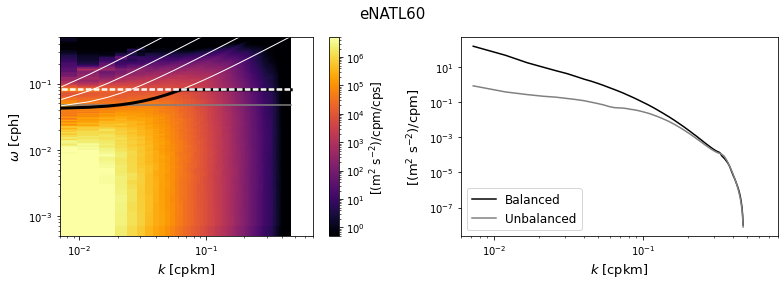

In [38]:
enatlf = xr.DataArray(xr.apply_ufunc(gsw.f, enatlw.lat, dask='parallelized').data,
                      dims=['YC','XC'], coords={'YC':U_enatlw.YC,'XC':U_enatlw.XC})
omega = np.sqrt(((enatlf.isel(YC=0))**2).mean() 
                + cs**2*(isoFu_enatlw.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_enatlw.freq_r.isel(freq_r=slice(1,None))}
                    )


plot(.5*(isoFu_enatlw + isoFv_enatlw),
     omega, enatlf)

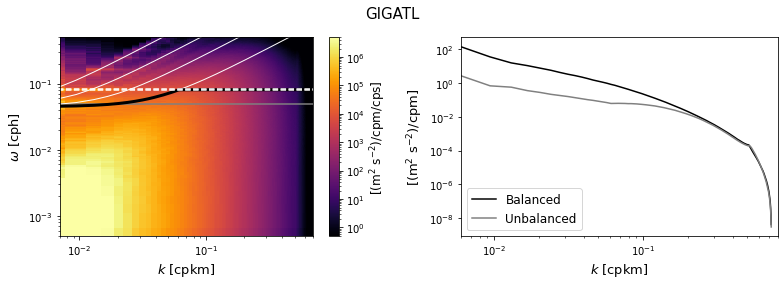

In [39]:
gigaf = xr.DataArray(gigaw.f.data,
                     dims=['YC','XC'], coords={'YC':U_gigaw.YC,'XC':U_gigaw.XC})
omega = np.sqrt(((gigaw.f.isel(eta_rho=0))**2).mean() 
                + cs**2*(isoFu_gigaw.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_gigaw.freq_r.isel(freq_r=slice(1,None))}
                    )


plot(.5*(isoFu_gigaw + isoFv_gigaw),
     omega, gigaf, title=r"GIGATL")

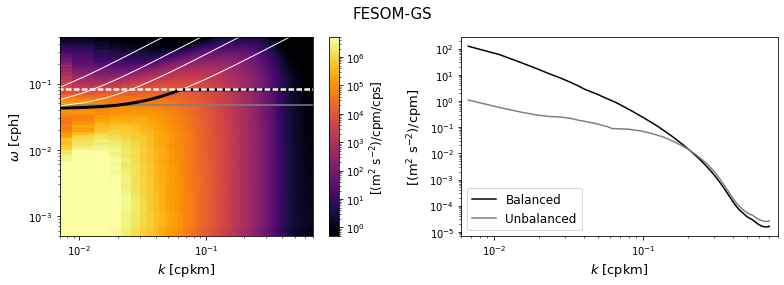

In [40]:
fesomf = xr.DataArray(xr.apply_ufunc(gsw.f, fesomw.lat, dask='parallelized').data,
                      dims='YC', coords={'YC':U_fesomw.YC})
omega = np.sqrt(((fesomf.isel(YC=0))**2).mean() 
                + cs**2*(isoFu_fesomw.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_fesomw.freq_r.isel(freq_r=slice(1,None))}
                    )


plot(.5*(isoFu_fesomw + isoFv_fesomw),
     omega, fesomf, title=r"FESOM-GS")

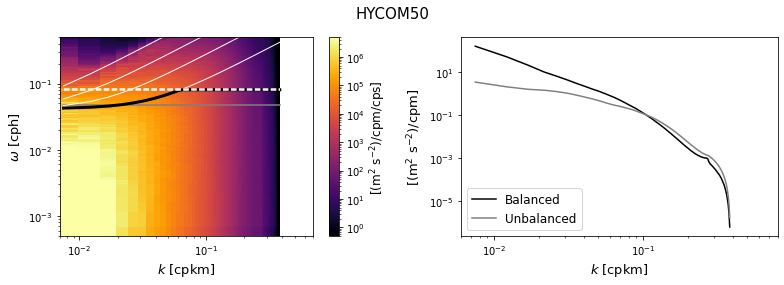

In [41]:
hycomf = xr.DataArray(xr.apply_ufunc(gsw.f, hycomw.latitude, dask='parallelized').data,
                      dims='YC', coords={'YC':U_hycomw.YC})
omega = np.sqrt(((hycomf.isel(YC=0))**2).mean() 
                + cs**2*(isoFu_hycomw.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_hycomw.freq_r.isel(freq_r=slice(1,None))}
                    )


plot(.5*(isoFu_hycomw + isoFv_hycomw),
     omega, hycomf, title=r"HYCOM50")

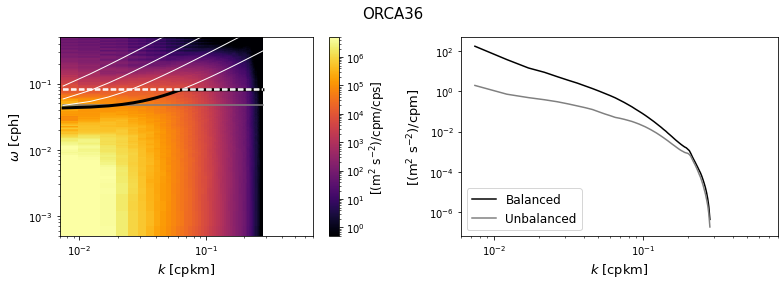

In [42]:
orcaf = xr.DataArray(xr.apply_ufunc(gsw.f, orcaw.nav_lat, dask='parallelized').data,
                     dims=['YC','XC'], coords={'YC':U_orcaw.YC,'XC':U_orcaw.XC})
omega = np.sqrt(((orcaf.isel(YC=0))**2).mean() 
                + cs**2*(isoFu_orcaw.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_orcaw.freq_r.isel(freq_r=slice(1,None))}
                    )


plot(.5*(isoFu_orcaw + isoFv_orcaw),
     omega, orcaf, title=r"ORCA36")

In [ ]:
client.close()